# Moon Dataset

This work is contributed  by Srujan: 200240128033 and Mohit: 200240128015

In this notebook we will be building a multilayer neural network from scratch, and train it using moon dataset from sklearn package. The dataset is a binary class classification dataset. We will be building a generalized neural network which will work for all classification datasets.

# **Importing necessary packages**

In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

import time 

from scipy.special import softmax
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

import random
random.seed(42)

# Building neural network

Our neural network consists of two hidden layers and one output layer. It can be trained in mini batches or can be trained by batch training. It takes following parameters while instantiating it's object:

1) number of independent features in the dataset

2) number of nodes in each hidden layers and output layer(as a list)

3) learning rate

4) regularization parameter

5) batch size 

In [2]:
class NeuralNetwork:
    
    def __init__(self,n_features,layers,l_rate,reg_lambda,batch_size):
        
        self.m = batch_size                        # m is number of samples in the dataset
        self.n = n_features                        # n in number of independent features
        
        self.l_rate = l_rate                       # learning rate 
        self.reg_lambda = reg_lambda               # regularization parameter
        
        # The weights and biases for all the layers are initialized randomly.
        self.W1 = np.random.rand(layers[0],self.n)
        self.b1 = np.random.rand(1,layers[0])
        
        self.W2 = np.random.rand(layers[1],layers[0])
        self.b2 = np.random.rand(1,layers[1])
        
        self.W3 = np.random.rand(layers[2],layers[1])
        self.b3 = np.random.rand(1,layers[2])
        
        # model is a dictionary which stores the weights and biases of all the layers for every epoch
        # this helps is retreiving the parameters if there is a scope of early stopping 
        self.model = {'epoch':[],'W1':[],'b1':[],'W2':[],'b2':[],'W3':[],'b3':[]}
        
    
    def update_model(self,epoch): # function to add weights and biases after every epoch
        
        self.model['epoch'].append(epoch)
        self.model['W1'].append(self.W1)
        self.model['b1'].append(self.b1)
        self.model['W2'].append(self.W2)
        self.model['b2'].append(self.b2)
        self.model['W3'].append(self.W3)
        self.model['b3'].append(self.b3)
        
        
    def tanh_derivative(self,a): # derivative of activation function which is useful in backpropagation
        
        return 1-np.power(a,2)
    
    def softmax(self,x): # softmax activation function for output layer
        
        return np.exp(x)/np.sum(np.exp(x),axis=1)
    
    def train(self,X,y):  # this involves both forward propagation and backward propagation
        
        self.X = X
        self.y = y
        
        # forward propagation
        
        self.Z1 = np.dot(self.X,self.W1.T)+self.b1
        self.A1 = np.tanh(self.Z1)
        
        assert(self.Z1.shape == self.A1.shape),'Z1 and A1 shapes not equal'
        
        self.Z2 = np.dot(self.A1,self.W2.T)+self.b2
        self.A2 =  np.tanh(self.Z2)
        
        assert(self.Z2.shape == self.A2.shape),'Z2 and A2 shapes not equal'
        
        self.Z3 = np.dot(self.A2,self.W3.T)+self.b3
        self.y_hat = softmax(self.Z3,axis=1)
        
        
        # backward propagation
        
        self.y = self.y.reshape(self.y_hat.shape) # reshaping y into y_hat's shape to avoid wrong calculations 
        
        #layer 3
        self.dZ3 = self.y_hat - self.y 
        
        self.dW3 = (1/self.m) * np.dot(self.dZ3.T,self.A2)
        
        self.db3 = (1/self.m) * np.sum(self.dZ3,axis=0,keepdims=True)
        
        assert self.dW3.shape == self.W3.shape
        assert self.db3.shape == self.b3.shape

        #layer 2
        self.dZ2 = np.multiply( np.dot(self.dZ3,self.W3) , self.tanh_derivative(self.A2) )
        
        assert self.dZ2.shape == self.A2.shape,"dZ2 and A2 shapes not equal"
        
        self.dW2 = (1/self.m) * np.dot(self.dZ2.T,self.A1)
        
        self.db2 = (1/self.m) * np.sum(self.dZ2,axis=0,keepdims=True)
        
        assert self.dW2.shape == self.W2.shape
        assert self.db2.shape == self.b2.shape
        
        #layer 1
        
        self.dZ1 = np.multiply( np.dot(self.dZ2,self.W2) , self.tanh_derivative(self.A1) )
        
        self.dW1 = (1/self.m) * np.dot(self.dZ1.T,self.X)
        
        self.db1 = (1/self.m) * np.sum(self.dZ1,axis=0,keepdims=True)
        
        
        # regularizing to reduce overfitting 
        self.dW3 = self.dW3 + self.reg_lambda * self.W3   / self.m
        self.db3 = self.db3 + self.reg_lambda * self.b3   / self.m
        self.dW2 = self.dW2 + self.reg_lambda * self.W2   / self.m
        self.db2 = self.db2 + self.reg_lambda * self.b2   / self.m
        self.dW1 = self.dW1 + self.reg_lambda * self.W1   / self.m        
        self.db2 = self.db2 + self.reg_lambda * self.b2   / self.m
        
        self.W3 = self.W3 - self.l_rate * self.dW3 # updating weights
        self.b3 = self.b3 - self.l_rate * self.db3 # updating bias
        self.W2 = self.W2 - self.l_rate * self.dW2 # updating weights
        self.b2 = self.b2 - self.l_rate * self.db2 # updating bias
        self.W1 = self.W1 - self.l_rate * self.dW1 # updating weights
        self.b1 = self.b1 - self.l_rate * self.db1 # updating bias
        
    def cost(self):
        
        loss = (-1/self.m) * np.sum ((np.multiply(np.log(self.y_hat),self.y)))
        
        loss = loss + (self.reg_lambda / (2*self.m) )*(np.sum(self.W1**2) + \
                                                     np.sum(self.W2**2) + \
                                                     np.sum(self.W3**2))
        
        return loss
    
    def predict(self,x):
        
        Z1 = np.dot(x,self.W1.T) + self.b1 
        
        A1 = np.tanh(Z1)
        
        Z2 = np.dot(A1,self.W2.T) + self.b2
        
        A2 = np.tanh(Z2)
        
        Z3 = np.dot(A2,self.W3.T) + self.b3
        
        y_hat = softmax(Z3)  

        preds = np.argmax(y_hat,axis=1)
        
        y_preds = [1 if i>0.5 else 0 for i in preds]
        
        return y_preds

# Generating dataset

In [3]:
X,y = datasets.make_moons(n_samples=1000,shuffle=True,random_state=42,noise=0.2)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y ,random_state=42)

In [4]:
# converting x and y into arrays
X = np.array(X)
y = np.array(y).reshape(-1,1)

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

One hot encoding target feature since we have softmax activation function in final layer

In [6]:
onehot = OneHotEncoder(sparse=False)
y_transformed_train = onehot.fit_transform(y_train)
y_transformed_test = onehot.transform(y_test)

# Batch training

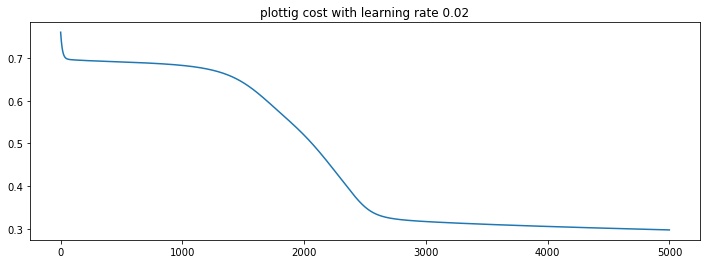

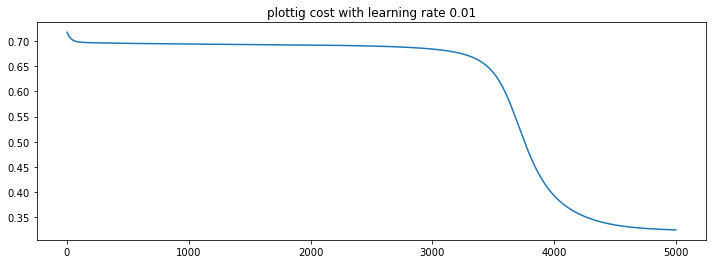

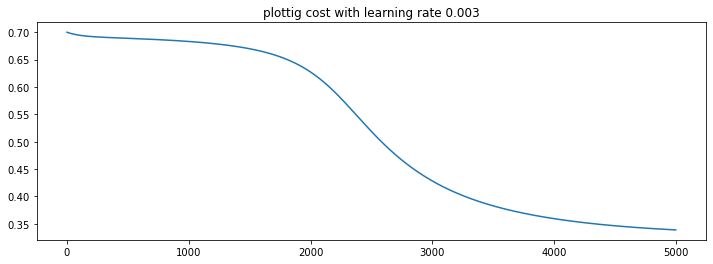

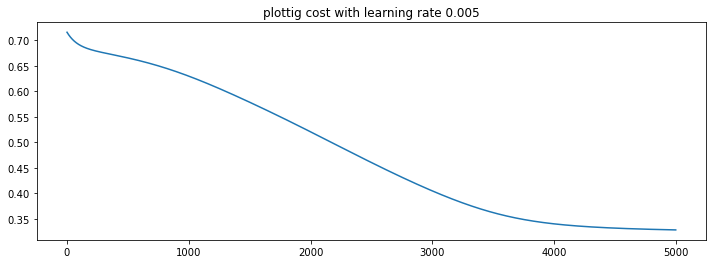

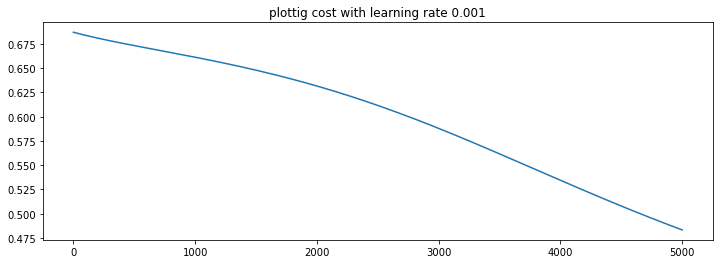

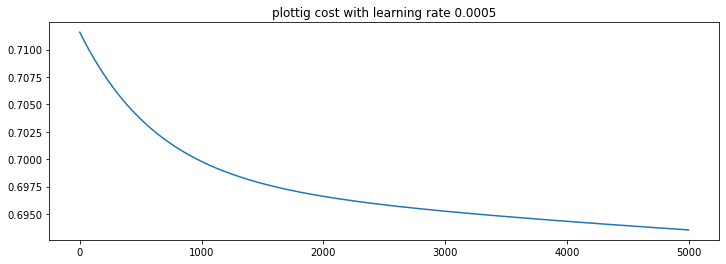

In [7]:
learning_rates = [0.02,0.01,0.003,0.005,0.001,0.0005]
n_classes = y_transformed_train.shape[1]
n_features = X_train.shape[1]

batch_size = X_train.shape[0]

metrics = {'learning_rate':[],'train_accuracy':[],'test_accuracy':[],'confusion matrix':[]}

for lr in learning_rates: 
    cost_list = []
    n = NeuralNetwork(n_features,[3,3,n_classes],lr,0.003,batch_size)

    for epoch in range(0,5000):
        n.train(X_train,y_transformed_train) 

        n.update_model(epoch)   
        cost_list.append(n.cost())
        
    plt.figure(figsize=(12,4)) # plotting cost for every learning rate
    x_vals = list(range(5000))
    sns.lineplot(x=x_vals,y=cost_list)
    plt.title(f'plottig cost with learning rate {lr}')
    
    y_train_preds = n.predict(X_train)  # converting output of sigmoid into predictions
    y_test_preds = n.predict(X_test)
    
    train_accuracy = accuracy_score(y_train,y_train_preds)
    test_accuracy = accuracy_score(y_test,y_test_preds)
    
    #adding to dictionary
    metrics['learning_rate'].append(lr)
    metrics['train_accuracy'].append(train_accuracy)
    metrics['test_accuracy'].append(test_accuracy)
    metrics['confusion matrix'].append(confusion_matrix(y_test,y_test_preds))

You can see that for learning rates 0.005,0.003,0.001 and 0.0005, 5000 epochs are not enough to reach global minimum. 
They are still stuck at local minimum.We will have to provide more epochs for it to reach global minimum.

In [8]:
metrics = pd.DataFrame(metrics)
metrics

,learning_rate,train_accuracy,test_accuracy,confusion matrix
0,0.0200,0.86375,0.930,"[[95, 5], [9, 91]]"
1,0.0100,0.85750,0.910,"[[95, 5], [13, 87]]"
2,0.0030,0.86000,0.905,"[[95, 5], [14, 86]]"
3,0.0050,0.85375,0.915,"[[94, 6], [11, 89]]"
4,0.0010,0.78500,0.810,"[[77, 23], [15, 85]]"
5,0.0005,0.50000,0.500,"[[100, 0], [100, 0]]"


# Tuning only learning rate with mini batch training

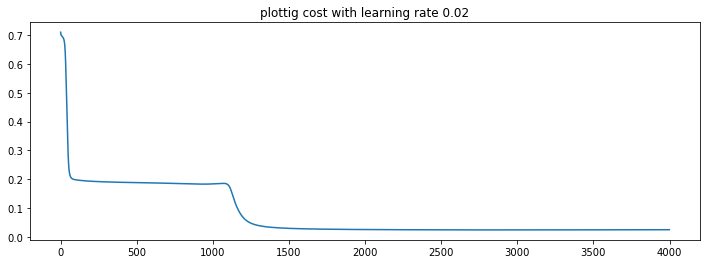

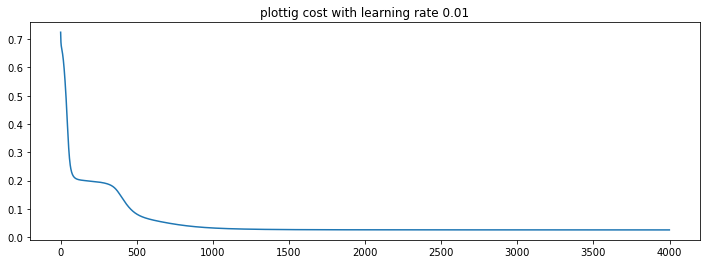

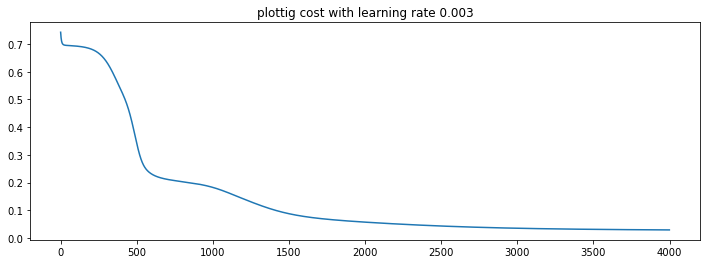

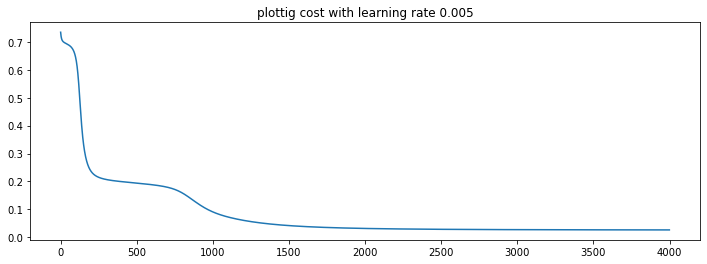

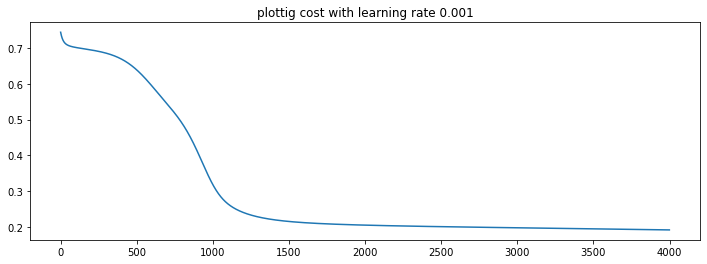

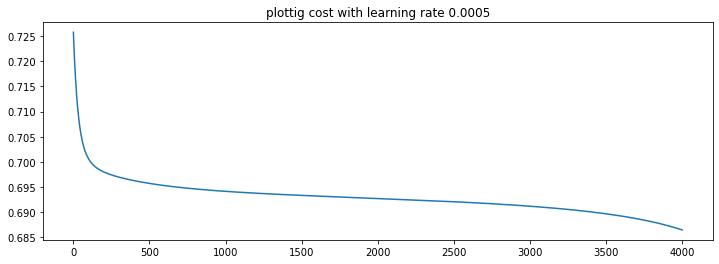

In [9]:
learning_rates = [0.02,0.01,0.003,0.005,0.001,0.0005]
n_classes = y_transformed_train.shape[1]
n_samples = X_train.shape[1]

batch_size=32
metrics = {'learning_rate':[],'train_accuracy':[],'test_accuracy':[],'confusion matrix':[]}

for lr in learning_rates: 
    cost_list = []
    n = NeuralNetwork(n_samples,[3,3,n_classes],lr,0.003,batch_size)

    for epoch in range(0,4000):
        start = 0                                                #batch starting index
        end = batch_size
        while (end <= X_train.shape[0]):

            x_trainable = X_train[start:end,:]                    
            y_trainable = y_transformed_train[start:end,:]
            n.train(x_trainable,y_trainable)                     # batch size training
            start = start+batch_size
            end = end+batch_size                                 # updating indexes of batch size 

        n.update_model(epoch)   
        cost_list.append(n.cost())
        
    plt.figure(figsize=(12,4)) # plotting cost for every learning rate
    x_vals = list(range(4000))
    sns.lineplot(x=x_vals,y=cost_list)
    plt.title(f'plottig cost with learning rate {lr}')
    
    y_train_preds = n.predict(X_train)  # converting output of sigmoid into predictions
    y_test_preds = n.predict(X_test)
    
    train_accuracy = accuracy_score(y_train,y_train_preds)
    test_accuracy = accuracy_score(y_test,y_test_preds)
    #adding to dictionary
    metrics['learning_rate'].append(lr)
    metrics['train_accuracy'].append(train_accuracy)
    metrics['test_accuracy'].append(test_accuracy)
    metrics['confusion matrix'].append(confusion_matrix(y_test,y_test_preds))

You can observe that loss for mini batch training is less compared to batch training for same number of epochs. This is because the weights get updated for every batch in mini batch training while in batch training weights get updated for every epoch.

In [10]:
metrics = pd.DataFrame(metrics)
metrics

,learning_rate,train_accuracy,test_accuracy,confusion matrix
0,0.0200,0.97375,0.985,"[[98, 2], [1, 99]]"
1,0.0100,0.97375,0.985,"[[98, 2], [1, 99]]"
2,0.0030,0.97375,0.985,"[[98, 2], [1, 99]]"
3,0.0050,0.97125,0.990,"[[99, 1], [1, 99]]"
4,0.0010,0.87125,0.930,"[[95, 5], [9, 91]]"
5,0.0005,0.56500,0.595,"[[96, 4], [77, 23]]"


# Tuning all parameters with mini batch training¶

In [ ]:
learning_rates = [0.02,0.01,0.003,0.005,0.001,0.0005]
n_classes = y_transformed_train.shape[1]
n_samples = X_train.shape[1]
metrics = {'learning_rate':[],'nodes':[],'reg_param':[],'batch_size':[],'train_accuracy':[],'test_accuracy':[],'confusion matrix':[]}

for lr in learning_rates: # tuning learning rate
    
    # tuning nodes in hidden layers
    for nodes in [[2,3,n_classes],[3,3,n_classes],[4,3,n_classes],[3,4,n_classes],[4,5,n_classes],[4,4,n_classes]]:
        
        for reg_param in [0.003,0.005,0.01]: # tuning regularization parameter
            
            for batch_size in [32,62,128]: # tuning batch size
            
                n = NeuralNetwork(n_samples,nodes,lr,reg_param,batch_size)
                
                for epoch in range(0,3000):
                    start = 0                                                #batch starting index
                    end = batch_size
                    while (end <= X_train.shape[0]):

                        x_trainable = X_train[start:end,:]                    
                        y_trainable = y_transformed_train[start:end,:]
                        n.train(x_trainable,y_trainable)                     # batch size training
                        start = start+batch_size
                        end = end+batch_size                                 # updating indexes of batch size 
                    
                    n.update_model(epoch)   
                    
                y_train_preds = n.predict(X_train)  # converting output of sigmoid into predictions
                y_test_preds = n.predict(X_test)
                
                train_accuracy = accuracy_score(y_train,y_train_preds)
                test_accuracy = accuracy_score(y_test,y_test_preds)
                
                # adding to dictionary
                metrics['learning_rate'].append(lr)
                metrics['nodes'].append(nodes)
                metrics['reg_param'].append(reg_param)
                metrics['batch_size'].append(batch_size)
                metrics['train_accuracy'].append(train_accuracy)
                metrics['test_accuracy'].append(test_accuracy)    
                metrics['confusion matrix'].append(confusion_matrix(y_test,y_test_preds))

In [ ]:
metrics = pd.DataFrame(metrics)
metrics